## Imports / Helper Functions

#### Imports

In [1]:
import pandas as pd
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, auc
from sklearn.model_selection import train_test_split
import numpy as np
import json
from scipy import stats
import random
import math
import gemmi
from sklearn.decomposition import PCA
import time
import sys
from scipy.stats import pearsonr, skew, kurtosis
import pickle
from tqdm.notebook import tqdm
import os
import re
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# scaled - reconstructed

In [2]:
reindexed = json.load(open("../PTP1B_DK/mtzs_reindex/reindex.json"))
bound_samples = json.load(open("../PTP1B_DK/bound_samples.json"))

In [3]:
samples = json.load(open("../PTP1B_DK/samples.json"))
apo_samples = json.load(open("../PTP1B_DK/apo_samples.json"))

In [104]:
samples_to_smiles = pd.read_csv('../sample_to_smiles.csv')

#### Ligand Cif Processing

In [99]:
ligand_cif = []

with open('../PTP1B_DK/ligand_cif_to_dataset_mapping.txt') as f:
    lines = f.readlines()
    
for line in lines:
    dataset, ligands = line[:-1].split(":")
    ligands = list(filter(None,ligands.split(" ")))
    ligand_cif.append([dataset, ligands, 0 if len(ligands) > 0 else 1])
    
ligand_cif = pd.DataFrame(ligand_cif, columns=["Dataset", "Ligands", "Apo"])

apo_samples = ligand_cif[ligand_cif['Apo'] == 1]['Dataset'].tolist()
apo_samples = [sample.split('y')[1] for sample in apo_samples]

samples = ligand_cif['Dataset'].tolist()
samples = [sample.split('y')[1] for sample in samples]

In [7]:
with open('../PTP1B_DK/samples.json', 'w') as f:
    json.dump(samples, f)

In [120]:
with open('../PTP1B_DK/apo_samples.json', 'w') as f:
    json.dump(apo_samples, f)

In [100]:
def extract_numbers(s):
    # Find all sequences of 4 consecutive digits
    pattern = r'\d{4}'
    numbers = re.findall(pattern, s)
    if numbers:
        return numbers[0]
    return None

def extract_smiles_string(filename):
    pattern = r'SMILES string: (\S+)'
    with open(filename, 'r') as f:
        for line in f:
            match = re.search(pattern, line)
            if match:
                return match.group(1)
    return None

def get_all_smiles(lst):
    result = []
    for elt in lst:
        result.append(extract_smiles_string('../PTP1B_DK/ligand_cifs/' + elt))
    return result

In [101]:
ligand_cif['sample'] = [int(extract_numbers(x)) for x in ligand_cif['Dataset']]

In [102]:
ligand_cif['SMILES_string'] = [get_all_smiles(x) for x in ligand_cif['Ligands']]

In [103]:
ligand_cif[['sample', 'SMILES_string']].to_csv('../sample_to_smiles.csv', index=False)

#### Moving to Cell

In [5]:
def move2cell(cartesian_coordinates, unit_cell, fractionalize=True):
    '''
    Move your points into a unitcell with translational vectors
    
    Parameters
    ----------
    cartesian_coordinates: array-like
        [N_points, 3], cartesian positions of points you want to move
        
    unit_cell, gemmi.UnitCell
        A gemmi unitcell instance
    
    fractionalize: boolean, default True
        If True, output coordinates will be fractional; Or will be cartesians
    
    Returns
    -------
    array-like, coordinates inside the unitcell
    '''
    o2f_matrix = np.array(unit_cell.fractionalization_matrix)
    frac_pos = np.dot(cartesian_coordinates, o2f_matrix.T) 
    frac_pos_incell = frac_pos % 1
    if fractionalize:
        return frac_pos_incell
    else:
        f2o_matrix = np.array(unit_cell.orthogonalization_matrix)
        return np.dot(frac_pos_incell, f2o_matrix.T)

#### Abstracted Automatic Pipeline

In [5]:
def generate_diff_map_stats(path_to_mtzs, diff_col, phase_col):

    # Assumes file name is in PTP1B-y{sample}_mrflagsref... form.

    stats = []
    
    for file_path in tqdm(os.listdir(path_to_mtzs)):

        try:
            # check if mtz exists, read diff_map, reindex if necessary
            diff_map = rs.read_mtz(path_to_mtzs + file_path)[[diff_col, phase_col]].dropna()
            sample = re.search('[0-9]{4}', file_path).group()

        except: 
            continue

        diff_map_gemmi=diff_map.to_gemmi()
        diff_map_grid = diff_map_gemmi.transform_f_phi_to_map(diff_col, phase_col, sample_rate=3)
        diff_map_grid.normalize()

        ######################################## COMPUTE BASIC STATS ################################################################
        diff_map_array = np.array(diff_map_grid).flatten()
        mean, sigma = np.mean(diff_map_array), np.std(diff_map_array)

        sample_stats = {
            "sample"  :    sample,
            "reindex" :    0 if sample in reindexed["0"] else 1,
            "bound"   :    1 if sample in bound_samples else 0,
            "mean"    :    mean,
            "sd"      :    sigma,
            "skew"    :    skew(diff_map_array),
            "kurtosis":    kurtosis(diff_map_array)

        }

        stats.append(sample_stats)
    
    return pd.DataFrame(stats)

In [6]:
def generate_diff_map_blobs(samples, mtz_file_fxn, structure_file_fxn, diff_col, phase_col, cutoff=4, min_volume=10, min_score=0, min_peak=5, negate=False):
    
    peaks = []
    blob_stats = []

    for sample_no in tqdm(samples):

        try:
            sample = rs.read_mtz(mtz_file_fxn(sample_no))[[diff_col, phase_col]].dropna()
            structure = gemmi.read_pdb(structure_file_fxn(sample_no))

        except:
            continue

        sample_gemmi=sample.to_gemmi()
        grid = sample_gemmi.transform_f_phi_to_map(diff_col, phase_col, sample_rate=3)
        grid.normalize()

        mean, sigma = np.mean(np.array(grid)), np.std(np.array(grid))

        blobs = gemmi.find_blobs_by_flood_fill(grid, cutoff=cutoff, min_volume=min_volume, min_score=min_score, min_peak=min_peak, negate=negate)

        use_long_names = False
        sort_by_key='peakz'

        ns = gemmi.NeighborSearch(structure[0], structure.cell, 5).populate()
        count = 0

        for blob in blobs:

            blob_stat = {
                "sample"  :    sample_no,
                "peakz"   :    (blob.peak_value-mean)/sigma,
                "scorez"  :    (blob.score-mean)/sigma,
                "peak"    :    blob.peak_value,
                "score"   :    blob.score,
                "cenx"    :    blob.centroid.x,
                "ceny"    :    blob.centroid.y,
                "cenz"    :    blob.centroid.x,
                "reindex" :    0 if sample_no in reindexed["0"] else 1,
                "bound"   :    1 if sample_no in bound_samples else 0,
            }

            blob_stats.append(blob_stat)

            #This is a list of weird pointer objects. It is safest to convert them `gemmi.CRA` objects (see below)
            marks = ns.find_atoms(blob.centroid)
            if len(marks) == 0:
                continue

            cra = dist = None
            for mark in marks:
                image_idx = mark.image_idx
                cra = mark.to_cra(structure[0])
                dist = structure.cell.find_nearest_pbc_image(blob.centroid, cra.atom.pos, mark.image_idx).dist()

                record = {
                    "sample"  :    sample_no,
                    "chain"   :    cra.chain.name,
                    "seqid"   :    cra.residue.seqid.num,
                    "residue" :    cra.residue.name,
                    "atom"    :    cra.atom.name,
                    "element" :    cra.atom.element.name,
                    "peakz"   :    (blob.peak_value-mean)/sigma,
                    "scorez"  :    (blob.score-mean)/sigma,
                    "peak"    :    blob.peak_value,
                    "score"   :    blob.score,
                    "cenx"    :    blob.centroid.x,
                    "ceny"    :    blob.centroid.y,
                    "cenz"    :    blob.centroid.x,
                    "coordx"  :    cra.atom.pos.x,
                    "coordy"  :    cra.atom.pos.y,
                    "coordz"  :    cra.atom.pos.z,
                    "reindex" :    0 if sample_no in reindexed["0"] else 1,
                    "bound"   :    1 if sample_no in bound_samples else 0,
                }

                if negate:
                    negative_keys = ['peak', 'peakz', 'score', 'scorez']
                    for k in negative_keys:
                        record[k] = -record[k]
                peaks.append(record)
                
    return peaks, blob_stats

## Statistics (Old Phases)

In [11]:
reindex_bound_stats = stats_df[(stats_df['reindex'] == 1) & (stats_df['bound'] == 1)]
reindex_not_bound_stats = stats_df[(stats_df['reindex'] == 1) & (stats_df['bound'] == 0)]
reindex_stats = stats_df[(stats_df['reindex'] == 1)]

no_reindex_bound_stats = stats_df[(stats_df['reindex'] == 0) & (stats_df['bound'] == 1)]
no_reindex_not_bound_stats = stats_df[(stats_df['reindex'] == 0) & (stats_df['bound'] == 0)]
no_reindex_stats = stats_df[(stats_df['reindex'] == 0)]

bound_stats = stats_df[(stats_df['bound'] == 1)]
not_bound_stats = stats_df[(stats_df['bound'] == 0)]

In [12]:
stats_df['apo'] = [1 if x in apo_samples else 0 for x in stats_df['sample']]
apo_stats = stats_df[stats_df['apo'] == 1]
holo_stats = stats_df[stats_df['apo'] == 0]

#### Scatter Plot (Skew + Kurtosis)

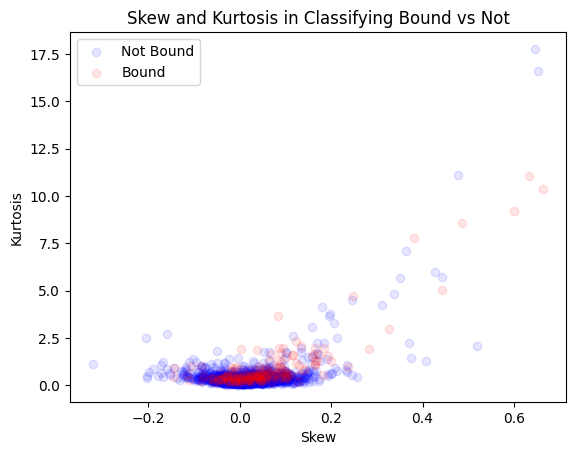

In [13]:
plt.scatter(not_bound_stats['skew'], not_bound_stats['kurtosis'], color="blue", label='Not Bound', alpha=0.1)
plt.scatter(bound_stats['skew'], bound_stats['kurtosis'], color="red", label='Bound', alpha=0.1)
plt.xlabel("Skew")
plt.ylabel("Kurtosis")
plt.title("Skew and Kurtosis in Classifying Bound vs Not")
plt.legend()
plt.show()

#### Histograms (Skew + Kurtosis)

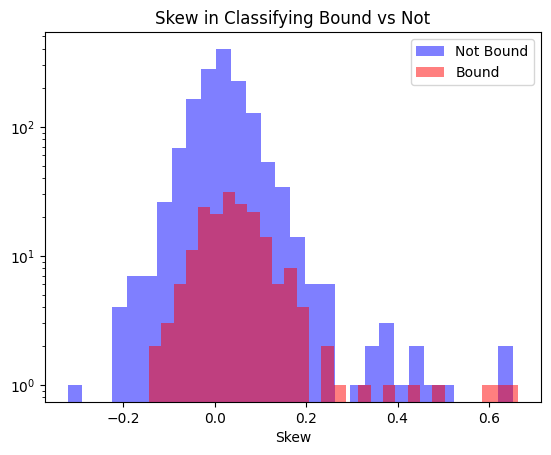

In [14]:
plt.hist(not_bound_stats['skew'], color="blue", label='Not Bound', alpha=0.5, bins=30)
plt.hist(bound_stats['skew'], color="red", label='Bound', alpha=0.5, bins=30)
plt.xlabel("Skew")
plt.yscale("log")
plt.title("Skew in Classifying Bound vs Not")
plt.legend()
plt.show()

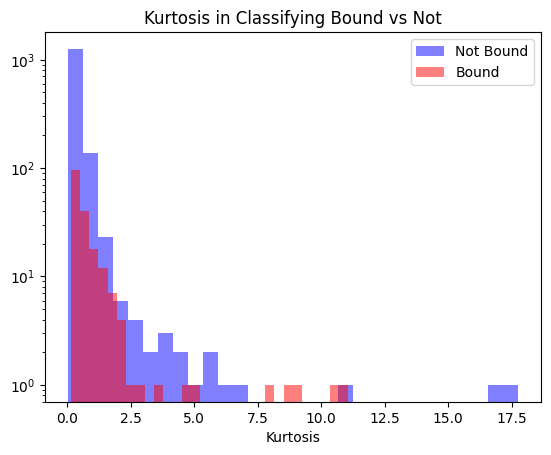

In [15]:
plt.hist(not_bound_stats['kurtosis'], color="blue", label='Not Bound', alpha=0.5, bins=30)
plt.hist(bound_stats['kurtosis'], color="red", label='Bound', alpha=0.5, bins=30)
plt.xlabel("Kurtosis")
plt.yscale("log")
plt.title("Kurtosis in Classifying Bound vs Not")
plt.legend()
plt.show()

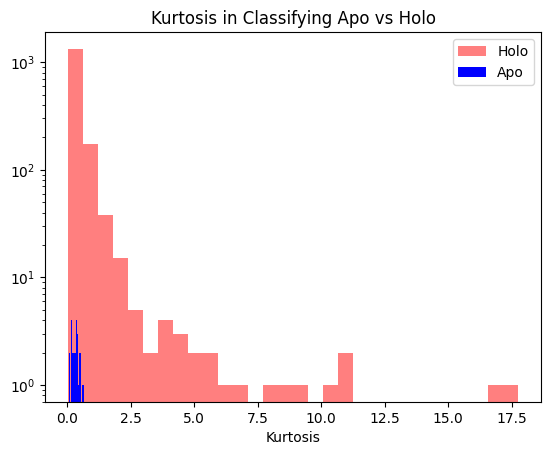

In [16]:
plt.hist(holo_stats['kurtosis'], color="red", label='Holo', alpha=0.5, bins=30)
plt.hist(apo_stats['kurtosis'], color="blue", label='Apo', alpha=1, bins=30)
plt.xlabel("Kurtosis")
plt.yscale("log")
plt.title("Kurtosis in Classifying Apo vs Holo")
plt.legend()
plt.show()

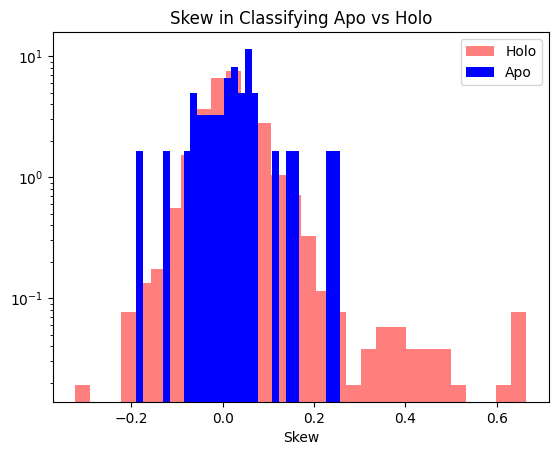

In [17]:
plt.hist(holo_stats['skew'], color="red", label='Holo', alpha=0.5, bins=30, density=True)
plt.hist(apo_stats['skew'], color="blue", label='Apo', alpha=1, bins=30, density=True)
plt.xlabel("Skew")
plt.yscale("log")
plt.title("Skew in Classifying Apo vs Holo")
plt.legend()
plt.show()

#### Why is it so bad? A deeper dive into the distributions...

In [18]:
lg, sm, lg_y, sm_y = train_test_split(stats_df, stats_df[['bound', 'reindex']], test_size=0.05, stratify=stats_df[['bound', 'reindex']])

In [19]:
sm = sm.sort_values(by='bound', ascending=False).reset_index(drop=True)

In [21]:
from scipy import stats

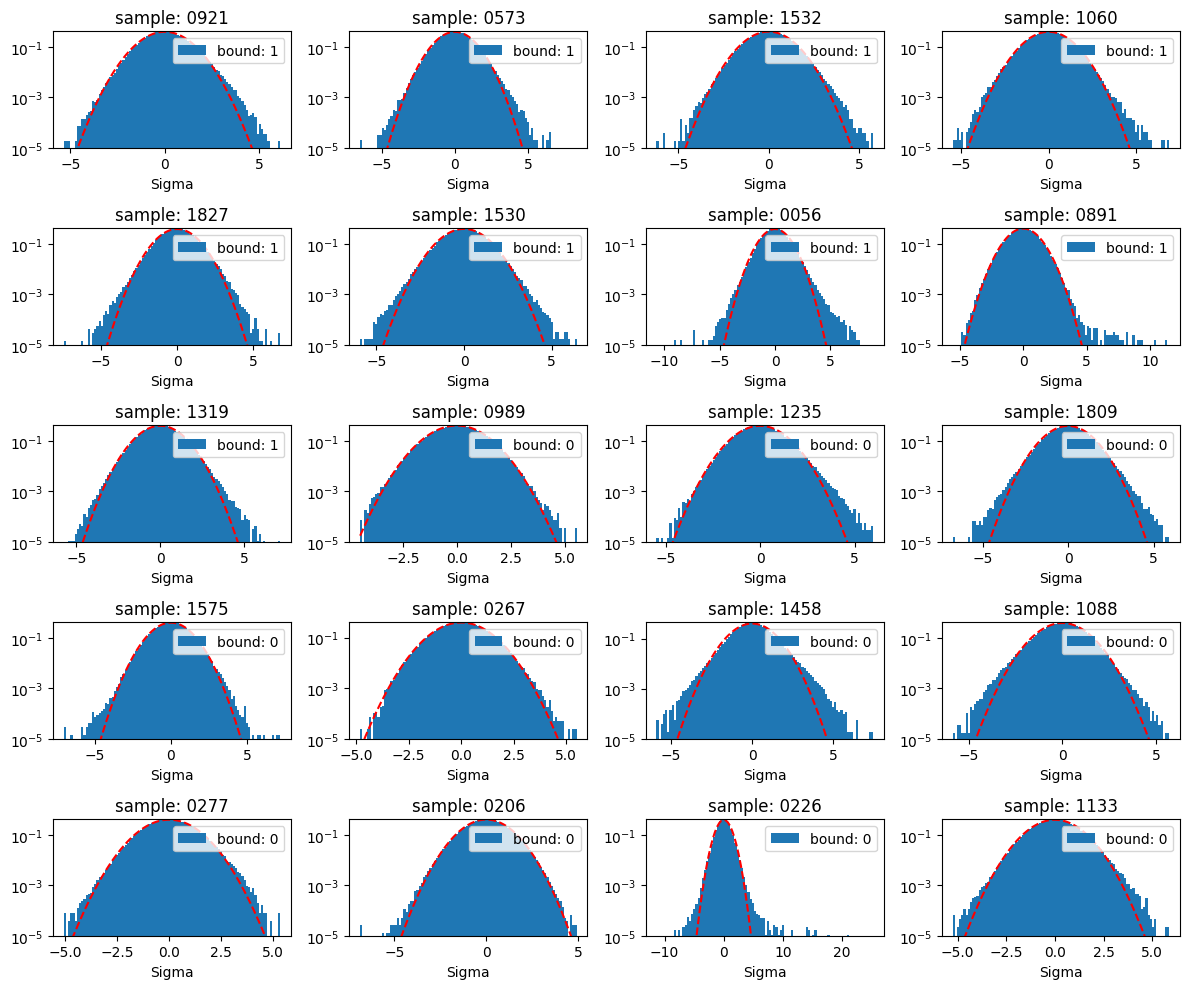

In [22]:
fig, ax = plt.subplots(5, 4, figsize=(12, 10))
for i in range(20):
    
    cur_sample = sm.loc[i]['sample']
    
    diff_map = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y{cur_sample}_mrflagsref_idxs_recons.mtz')[["F-obs-diff", "PHIFOFCWT"]].dropna()   

    diff_map_gemmi=diff_map.to_gemmi()
    diff_map_grid = diff_map_gemmi.transform_f_phi_to_map("F-obs-diff", "PHIFOFCWT", sample_rate=3)
    diff_map_grid.normalize()
    
    y_val, x, _= ax[i // 4][i % 4].hist(np.array(diff_map_grid).flatten(), bins=100, label=f'bound: {sm.loc[i]["bound"]}', density=True)
    
    
    ax[i // 4][i % 4].plot(x, stats.norm.pdf(x, 0, np.std(np.array(diff_map_grid).flatten())), color='red', linestyle='--')
    ax[i // 4][i % 4].set_ylim(0.00001, y_val.max())
    ax[i // 4][i % 4].set_yscale("log")
    ax[i // 4][i % 4].set_xlabel("Sigma")
    ax[i // 4][i % 4].set_title(f'sample: {cur_sample}')
    ax[i // 4][i % 4].legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Saving Stats (Skew + Kurtosis)

In [128]:
stats_df.sort_values(by="kurtosis", ascending=False).head(50)

,sample,reindex,bound,mean,sd,skew,kurtosis
451,0562,0,0,8.585031e-10,1.0,0.890992,26.332282
978,1194,1,0,-1.448724e-10,1.0,0.782997,24.728698
1495,1797,0,0,-8.585031e-10,1.0,0.764349,18.760547
50,0060,0,1,3.932251e-10,1.0,0.565029,16.089233
1287,1554,0,1,3.543029e-10,1.0,0.497533,13.448816
34,0043,1,0,2.173086e-10,1.0,0.409590,10.896392
1235,1492,1,1,-4.139212e-11,1.0,0.525567,9.173682
196,0226,1,0,1.552204e-10,1.0,0.422047,8.856756
1338,1608,0,1,1.098884e-09,1.0,0.597229,8.626728
1348,1618,1,1,-2.316596e-10,1.0,0.379820,8.574257


In [129]:
by_kurtosis = stats_df.sort_values(by="kurtosis", ascending=False).reset_index(drop=True)

In [130]:
by_skew = stats_df.sort_values(by="skew", ascending=False).reset_index(drop=True)

In [131]:
stats_df.to_pickle('../PTP1B_DK/stats/stats_df.pkl')
by_kurtosis.to_pickle('../PTP1B_DK/stats/stats_df_by_kurtosis.pkl')
by_skew.to_pickle('../PTP1B_DK/stats/stats_df_by_skew.pkl')

#### CDFs (Skew + Kurtosis)

In [2]:
stats_df = pd.read_pickle('../PTP1B_DK/stats/stats_df.pkl')
by_kurtosis = pd.read_pickle('../PTP1B_DK/stats/stats_df_by_kurtosis.pkl')
by_skew = pd.read_pickle('../PTP1B_DK/stats/stats_df_by_skew.pkl')

In [133]:
by_kurtosis['bound_cdf'] = by_kurtosis['bound'].cumsum() / np.sum(by_kurtosis['bound'])

In [134]:
by_skew['bound_cdf'] = by_skew['bound'].cumsum() / np.sum(by_skew['bound'])

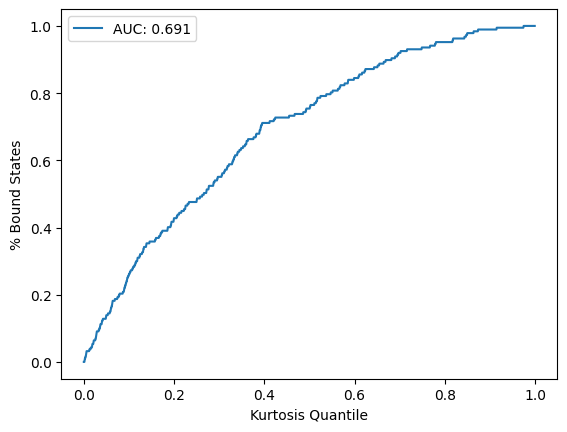

In [136]:
plt.plot(by_kurtosis.index / len(by_kurtosis), by_kurtosis['bound_cdf'],
        label=f'AUC: {round(auc(by_kurtosis.index / len(by_kurtosis), by_kurtosis["bound_cdf"]), 3)}')
plt.ylabel('% Bound States')
plt.xlabel('Kurtosis Quantile')
plt.legend()
plt.show()

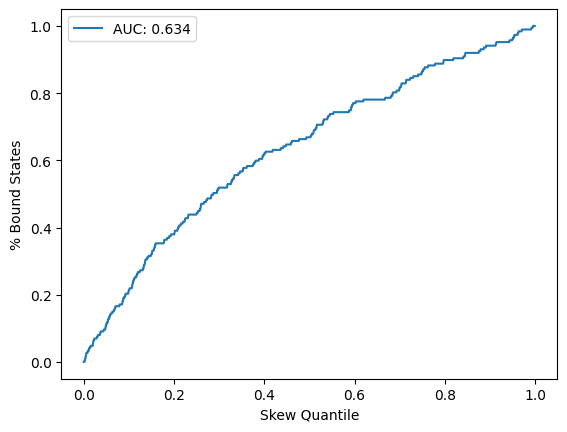

In [137]:
plt.plot(by_skew.index / len(by_skew), by_skew['bound_cdf'], 
         label=f'AUC: {round(auc(by_skew.index / len(by_skew), by_skew["bound_cdf"]), 3)}')
plt.ylabel('% Bound States')
plt.xlabel('Skew Quantile')
plt.legend()
plt.show()

#### AUC Curves

In [5]:
fpr, tpr, thresholds = metrics.roc_curve(by_kurtosis["bound"], by_kurtosis["kurtosis"], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

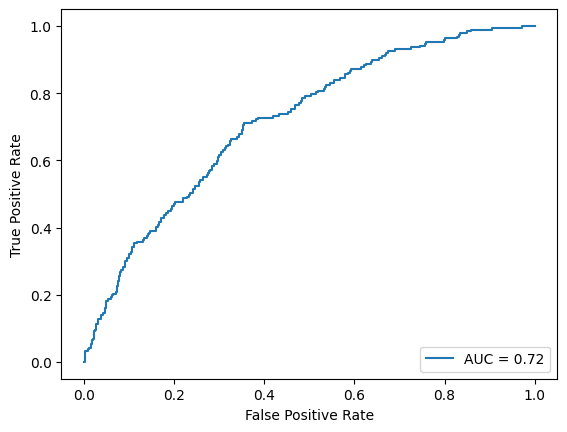

In [6]:
display.plot()

In [7]:
fpr, tpr, thresholds = metrics.roc_curve(by_skew["bound"], by_skew["skew"], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

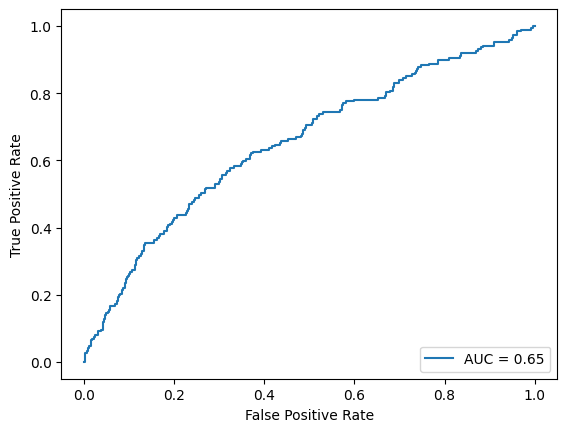

In [8]:
display.plot()

#### Jarque Bera Test

In [138]:
stats_df['jarque_bera'] = stats_df['skew']**2+(1/4)*(stats_df['kurtosis'])**2
by_jarque_bera = stats_df.sort_values(by="jarque_bera", ascending=False).reset_index(drop=True)
by_jarque_bera.to_pickle('../PTP1B_DK/stats/stats_df_by_jarque_bera.pkl')

In [139]:
by_jarque_bera = pd.read_pickle('../PTP1B_DK/stats/stats_df_by_jarque_bera.pkl')

In [140]:
by_jarque_bera['bound_cdf'] = by_jarque_bera['bound'].cumsum() / np.sum(by_jarque_bera['bound'])

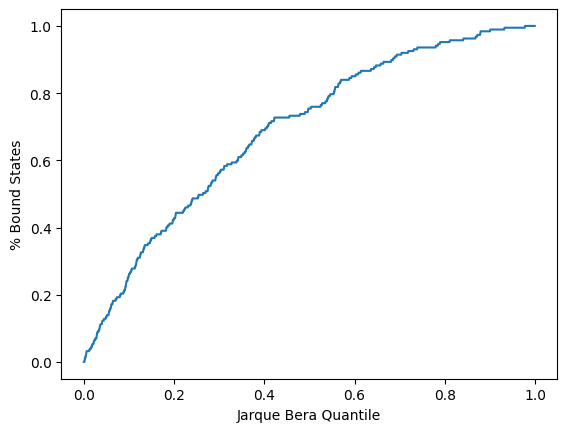

In [141]:
plt.plot(by_jarque_bera.index / len(by_jarque_bera), by_jarque_bera['bound_cdf'])
plt.ylabel('% Bound States')
plt.xlabel('Jarque Bera Quantile')
plt.show()

#### Find reconstructed PC values

In [23]:
recons_intersection = rs.read_mtz('../PTP1B_DK/recons_mtzs/intersection.mtz').T

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array


/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


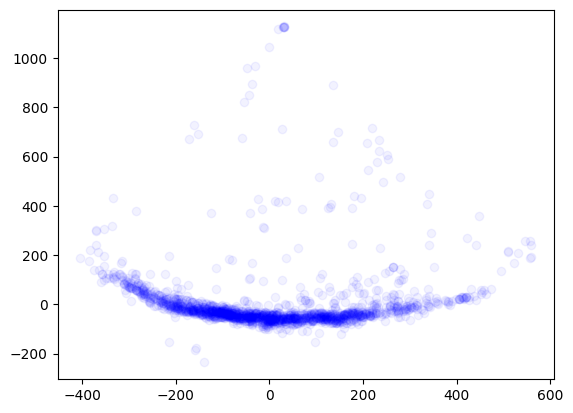

In [143]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(recons_intersection)
plt.scatter(principalComponents[:,0], principalComponents[:,1], c='blue', alpha=0.05)
plt.show()

In [144]:
recons_pc_values = pd.DataFrame(principalComponents, index=recons_intersection.index, columns=['PC1', 'PC2'])

In [145]:
recons_pc_values['sample'] = [x.split('_')[1] for x in recons_pc_values.index]
recons_pc_values = recons_pc_values[['sample', 'PC1', 'PC2']].reset_index(drop=True)

In [146]:
recons_pc_values.to_pickle('../PTP1B_DK/stats/recons_pc_values.pkl')

#### Relationship Between PC Value + (Skew / Kurtosis)

In [27]:
recons_pc_values = pd.read_pickle('../PTP1B_DK/stats/recons_pc_values.pkl')

In [28]:
by_kurtosis = pd.read_pickle('../PTP1B_DK/stats/stats_df_by_kurtosis.pkl')
by_skew = pd.read_pickle('../PTP1B_DK/stats/stats_df_by_skew.pkl')

In [29]:
by_kurtosis_pc = pd.merge(recons_pc_values, by_kurtosis, on=['sample'])
by_skew_pc = pd.merge(recons_pc_values, by_skew, on=['sample'])

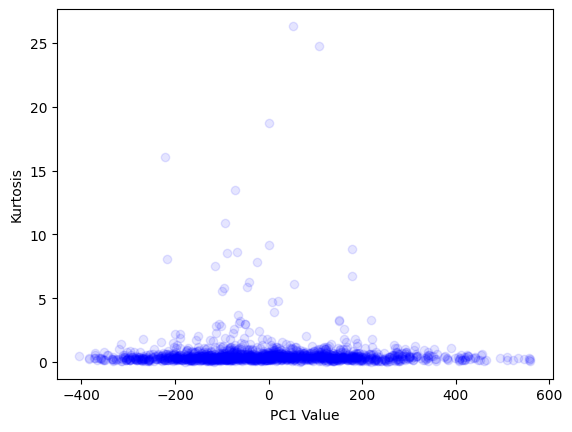

In [30]:
plt.scatter(by_kurtosis_pc['PC1'], by_kurtosis_pc['kurtosis'], c='blue', alpha=0.1)
plt.ylabel('Kurtosis')
plt.xlabel('PC1 Value')
plt.show()

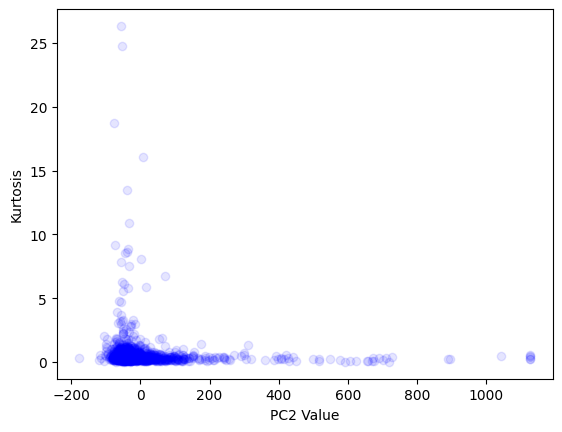

In [31]:
plt.scatter(by_kurtosis_pc['PC2'], by_kurtosis_pc['kurtosis'], c='blue', alpha=0.1)
plt.ylabel('Kurtosis')
plt.xlabel('PC2 Value')
plt.show()

In [36]:
by_kurtosis_pc = by_kurtosis_pc.astype({"sample": int})

In [37]:
by_kurtosis_r_factor = r_factors.merge(by_kurtosis_pc, left_on='data_id', right_on='sample')

In [41]:
by_kurtosis_high_r_factor = by_kurtosis_r_factor[by_kurtosis_r_factor['Rfree_final'] > 0.4]

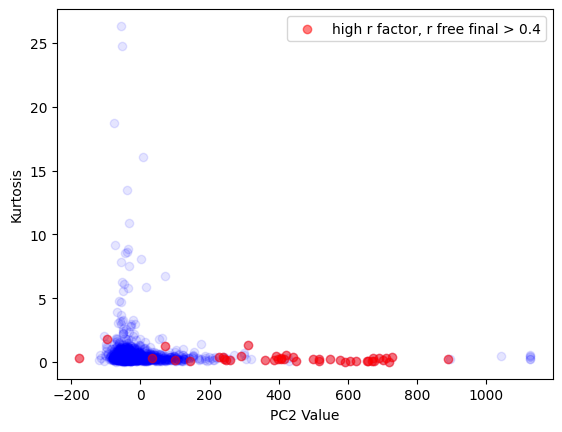

In [46]:
plt.scatter(by_kurtosis_pc['PC2'], by_kurtosis_pc['kurtosis'], c='blue', alpha=0.1)
plt.scatter(by_kurtosis_high_r_factor['PC2'], by_kurtosis_high_r_factor['kurtosis'], c='red', alpha=0.5, label="high r factor, r free final > 0.4")
plt.ylabel('Kurtosis')
plt.xlabel('PC2 Value')
plt.legend()
plt.show()

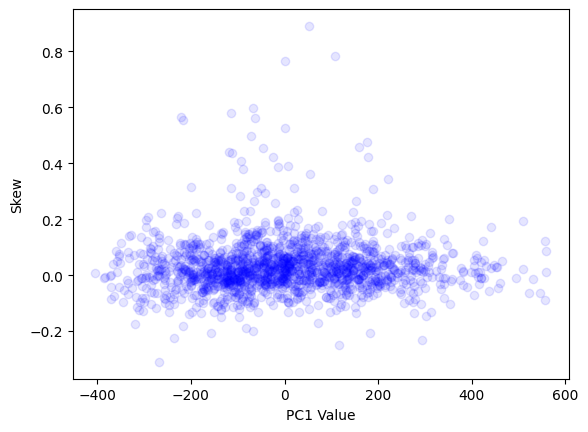

In [152]:
plt.scatter(by_skew_pc['PC1'], by_skew_pc['skew'], c='blue', alpha=0.1)
plt.ylabel('Skew')
plt.xlabel('PC1 Value')
plt.show()

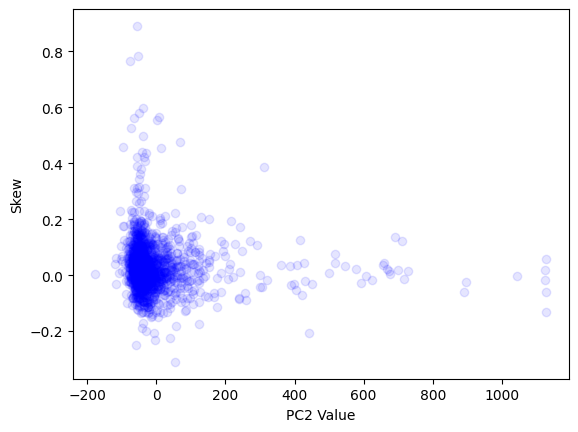

In [153]:
plt.scatter(by_skew_pc['PC2'], by_skew_pc['skew'], c='blue', alpha=0.1)
plt.ylabel('Skew')
plt.xlabel('PC2 Value')
plt.show()

#### PC Value of Mislabeled Kurtosis / Skew

In [154]:
top_20_kurtosis_bound_0 = by_kurtosis[by_kurtosis['bound'] == 0].head(20)
top_20_skew_bound_0 = by_skew[by_skew['bound'] == 0].head(20)

In [155]:
top_20_kurtosis_bound_0_pc = pd.merge(top_20_kurtosis_bound_0, recons_pc_values, on='sample')
top_20_skew_bound_0_pc = pd.merge(top_20_skew_bound_0, recons_pc_values, on='sample')

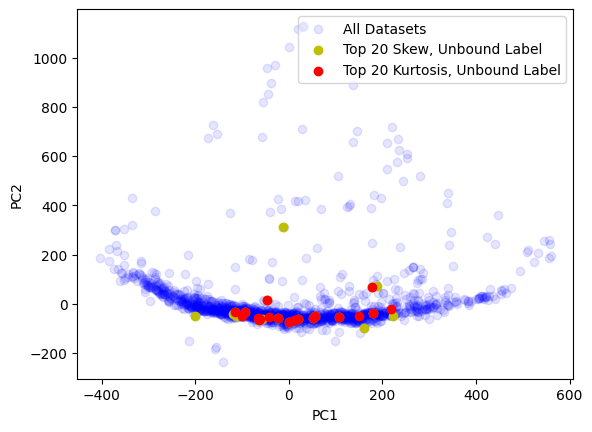

In [156]:
plt.scatter(recons_pc_values['PC1'], recons_pc_values['PC2'], alpha=0.1, c='b', label='All Datasets')
plt.scatter(top_20_skew_bound_0_pc['PC1'], top_20_skew_bound_0_pc['PC2'], alpha=1, c='y', label='Top 20 Skew, Unbound Label')
plt.scatter(top_20_kurtosis_bound_0_pc['PC1'], top_20_kurtosis_bound_0_pc['PC2'], c='r', label='Top 20 Kurtosis, Unbound Label')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [157]:
bottom_20_kurtosis_bound_1 = by_kurtosis[by_kurtosis['bound'] == 1].tail(20)
bottom_20_skew_bound_1 = by_skew[by_skew['bound'] == 1].tail(20)

In [158]:
bottom_20_kurtosis_bound_1_pc = pd.merge(bottom_20_kurtosis_bound_1, recons_pc_values, on='sample')
bottom_20_skew_bound_1_pc = pd.merge(bottom_20_skew_bound_1, recons_pc_values, on='sample')

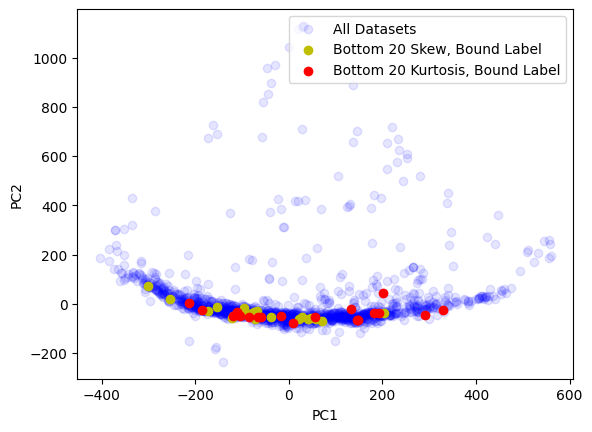

In [159]:
plt.scatter(recons_pc_values['PC1'], recons_pc_values['PC2'], alpha=0.1, c='b', label='All Datasets')
plt.scatter(bottom_20_skew_bound_1_pc['PC1'], bottom_20_skew_bound_1_pc['PC2'], alpha=1, c='y', label='Bottom 20 Skew, Bound Label')
plt.scatter(bottom_20_kurtosis_bound_1_pc['PC1'], bottom_20_kurtosis_bound_1_pc['PC2'], c='r', label='Bottom 20 Kurtosis, Bound Label')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Weights

In [227]:
stats_df = generate_diff_map_stats('../PTP1B_DK/weighted_mtzs/', 'weighted_F-obs-diff', 'PHIFOFCWT')

  0%|          | 0/1680 [00:00<?, ?it/s]

In [228]:
by_kurtosis = stats_df.sort_values(by="kurtosis", ascending=False).reset_index(drop=True)

In [229]:
by_skew = stats_df.sort_values(by="skew", ascending=False).reset_index(drop=True)

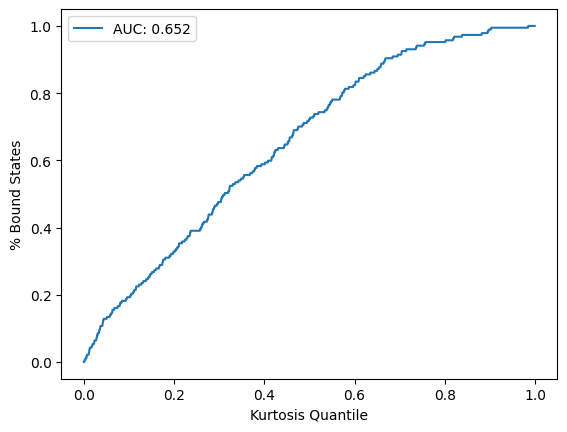

In [230]:
by_kurtosis['bound_cdf'] = by_kurtosis['bound'].cumsum() / np.sum(by_kurtosis['bound'])
plt.plot(by_kurtosis.index / len(by_kurtosis), by_kurtosis['bound_cdf'],
        label=f'AUC: {round(auc(by_kurtosis.index / len(by_kurtosis), by_kurtosis["bound_cdf"]), 3)}')
plt.ylabel('% Bound States')
plt.xlabel('Kurtosis Quantile')
plt.legend()
plt.show()

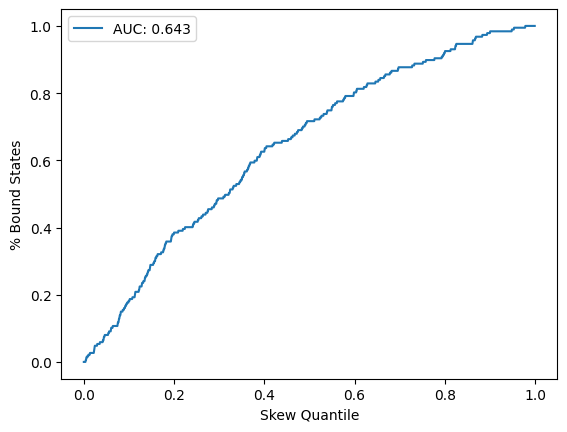

In [231]:
by_skew['bound_cdf'] = by_skew['bound'].cumsum() / np.sum(by_skew['bound'])
plt.plot(by_skew.index / len(by_skew), by_skew['bound_cdf'],
        label=f'AUC: {round(auc(by_skew.index / len(by_skew), by_skew["bound_cdf"]), 3)}')
plt.ylabel('% Bound States')
plt.xlabel('Skew Quantile')
plt.legend()
plt.show()

In [232]:
stats_df.to_pickle('../PTP1B_DK/stats/stats_df_weighted.pkl')
by_kurtosis.to_pickle('../PTP1B_DK/stats/stats_df_by_kurtosis_weighted.pkl')
by_skew.to_pickle('../PTP1B_DK/stats/stats_df_by_skew_weighted.pkl')

## Poor R Factors

In [15]:
r_factors = pd.read_csv('../pandda_input_models_refined/refine_stats.csv', index_col=0)

In [16]:
r_factors = r_factors.sort_values(by='Rfree_final', ascending=False)

In [17]:
high_r_factors = r_factors[r_factors['Rfree_final'] > 0.5]

#### Look at Smiley

In [2]:
recons_intersection = rs.read_mtz('../PTP1B_DK/recons_mtzs/intersection.mtz').T

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array


/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


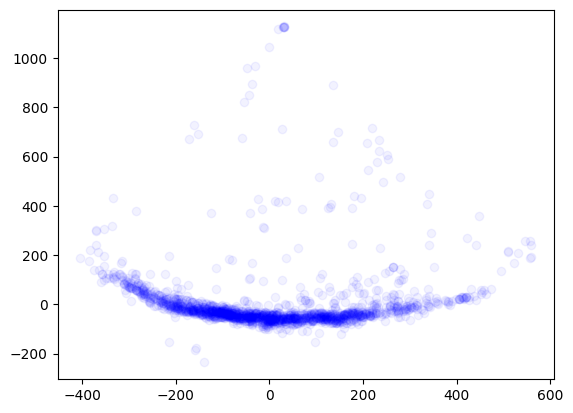

In [3]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(recons_intersection)
plt.scatter(principalComponents[:,0], principalComponents[:,1], c='blue', alpha=0.05)
plt.show()

In [11]:
recons_pc_values = pd.DataFrame(principalComponents, index=recons_intersection.index, columns=['PC1', 'PC2'])

In [12]:
recons_pc_values['sample'] = [x.split('_')[1] for x in recons_pc_values.index]
recons_pc_values = recons_pc_values[['sample', 'PC1', 'PC2']].reset_index(drop=True)

In [13]:
recons_pc_values = recons_pc_values.astype({"sample": int})

In [18]:
r_factors_pc = r_factors.merge(recons_pc_values, left_on='data_id', right_on='sample')

In [19]:
high_r_factors_pc = r_factors_pc[r_factors_pc['Rfree_final'] > 0.4]

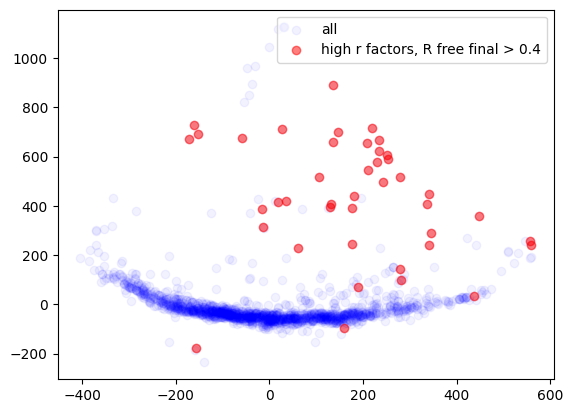

In [49]:
plt.scatter(principalComponents[:,0], principalComponents[:,1], c='blue', alpha=0.05, label="all")
plt.scatter(high_r_factors_pc["PC1"], high_r_factors_pc["PC2"], c='red', alpha=0.5, label="high r factors, R free final > 0.4")
plt.legend()
plt.show()

#### Check Bound States in Smiley

In [9]:
bound_samples=[int(x) for x in bound_samples]

In [22]:
r_factors_pc['bound'] = [1 if x in bound_samples else 0 for x in r_factors_pc['sample']]

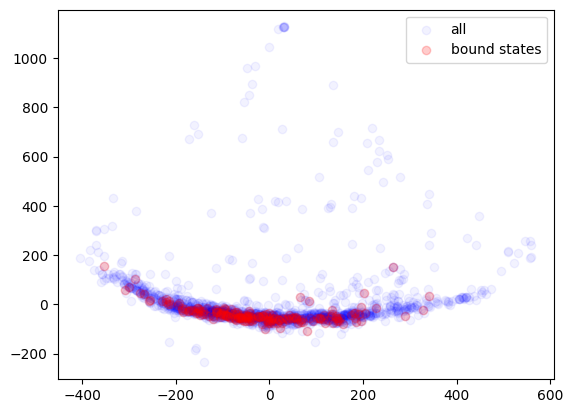

In [26]:
plt.scatter(principalComponents[:,0], principalComponents[:,1], c='blue', alpha=0.05, label="all")
bound_r_factors_pc = r_factors_pc[r_factors_pc['bound']==1]
plt.scatter(bound_r_factors_pc["PC1"], bound_r_factors_pc["PC2"], c='red', alpha=0.2, label="bound states")
plt.legend()
plt.show()

## Statistics with Refined Model (FO - FC)

In [103]:
r_factors = pd.read_csv('../pandda_input_models_refined/refine_stats.csv', index_col=0)

In [104]:
r_factors['sample'] = [f'{x:04}' for x in r_factors['data_id']]

In [105]:
# determine kurtosis and skew for each
# difference map is FOFCWT
results = generate_diff_map_stats('../pandda_input_models_refined/', 'FOFCWT', 'PHFOFCWT')    

  0%|          | 0/6509 [00:00<?, ?it/s]

../pandda_input_models_refined/PTP1B_y0556_pandda_input_reindexed_refine_001.mtz 0556
../pandda_input_models_refined/PTP1B_y1597_pandda_input_reindexed_refine_001.mtz 1597
../pandda_input_models_refined/PTP1B_y0451_pandda_input_reindexed_refine_001.mtz 0451
../pandda_input_models_refined/PTP1B_y0811_pandda_input_reindexed_refine_001.mtz 0811
../pandda_input_models_refined/PTP1B_y0929_pandda_input_reindexed_refine_001.mtz 0929
../pandda_input_models_refined/PTP1B_y0758_pandda_input_reindexed_refine_001.mtz 0758
../pandda_input_models_refined/PTP1B_y1347_pandda_input_reindexed_refine_001.mtz 1347
../pandda_input_models_refined/PTP1B_y0933_pandda_input_reindexed_refine_001.mtz 0933
../pandda_input_models_refined/PTP1B_y1089_pandda_input_reindexed_refine_001.mtz 1089
../pandda_input_models_refined/PTP1B_y1960_pandda_input_reindexed_refine_001.mtz 1960
../pandda_input_models_refined/PTP1B_y0550_pandda_input_reindexed_refine_001.mtz 0550
../pandda_input_models_refined/PTP1B_y1578_pandda_inpu

In [108]:
refine_stats_df = results.copy()
refine_stats_df['apo'] = [1 if x in apo_samples else 0 for x in refine_stats_df['sample']]
apo_stats = refine_stats_df[refine_stats_df['apo'] == 1]
holo_stats = refine_stats_df[refine_stats_df['apo'] == 0]

In [109]:
reindex_bound_stats = refine_stats_df[(refine_stats_df['reindex'] == 1) & (refine_stats_df['bound'] == 1)]
reindex_not_bound_stats = refine_stats_df[(refine_stats_df['reindex'] == 1) & (refine_stats_df['bound'] == 0)]
reindex_stats = refine_stats_df[(refine_stats_df['reindex'] == 1)]

no_reindex_bound_stats = refine_stats_df[(refine_stats_df['reindex'] == 0) & (refine_stats_df['bound'] == 1)]
no_reindex_not_bound_stats = refine_stats_df[(refine_stats_df['reindex'] == 0) & (refine_stats_df['bound'] == 0)]
no_reindex_stats = refine_stats_df[(refine_stats_df['reindex'] == 0)]

bound_stats = refine_stats_df[(refine_stats_df['bound'] == 1)]
not_bound_stats = refine_stats_df[(refine_stats_df['bound'] == 0)]

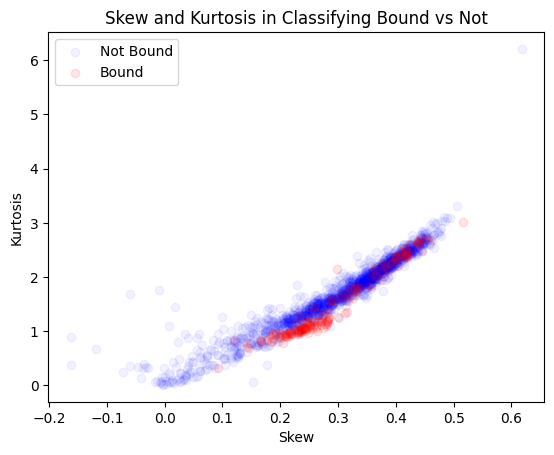

In [110]:
plt.scatter(not_bound_stats['skew'], not_bound_stats['kurtosis'], color="blue", label='Not Bound', alpha=0.05)
plt.scatter(bound_stats['skew'], bound_stats['kurtosis'], color="red", label='Bound', alpha=0.1)
plt.xlabel("Skew")
plt.ylabel("Kurtosis")
plt.title("Skew and Kurtosis in Classifying Bound vs Not")
plt.legend()
plt.show()

### Histograms

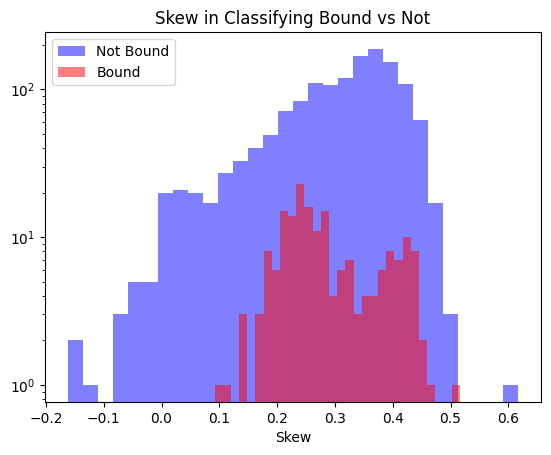

In [111]:
plt.hist(not_bound_stats['skew'], color="blue", label='Not Bound', alpha=0.5, bins=30)
plt.hist(bound_stats['skew'], color="red", label='Bound', alpha=0.5, bins=30)
plt.xlabel("Skew")
plt.yscale("log")
plt.title("Skew in Classifying Bound vs Not")
plt.legend()
plt.show()

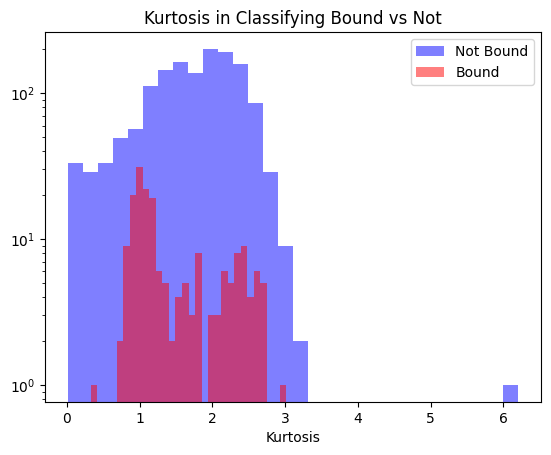

In [112]:
plt.hist(not_bound_stats['kurtosis'], color="blue", label='Not Bound', alpha=0.5, bins=30)
plt.hist(bound_stats['kurtosis'], color="red", label='Bound', alpha=0.5, bins=30)
plt.xlabel("Kurtosis")
plt.yscale("log")
plt.title("Kurtosis in Classifying Bound vs Not")
plt.legend()
plt.show()

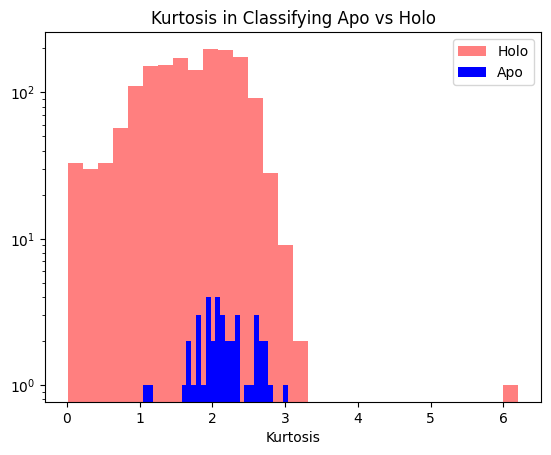

In [113]:
plt.hist(holo_stats['kurtosis'], color="red", label='Holo', alpha=0.5, bins=30)
plt.hist(apo_stats['kurtosis'], color="blue", label='Apo', alpha=1, bins=30)
plt.xlabel("Kurtosis")
plt.yscale("log")
plt.title("Kurtosis in Classifying Apo vs Holo")
plt.legend()
plt.show()

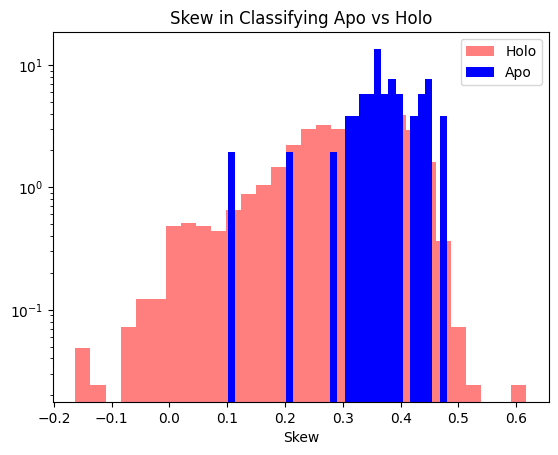

In [114]:
plt.hist(holo_stats['skew'], color="red", label='Holo', alpha=0.5, bins=30, density=True)
plt.hist(apo_stats['skew'], color="blue", label='Apo', alpha=1, bins=30, density=True)
plt.xlabel("Skew")
plt.yscale("log")
plt.title("Skew in Classifying Apo vs Holo")
plt.legend()
plt.show()

### Saving Stats

In [115]:
by_kurtosis = refine_stats_df.sort_values(by="kurtosis", ascending=False).reset_index(drop=True)
by_skew = refine_stats_df.sort_values(by="skew", ascending=False).reset_index(drop=True)

In [116]:
refine_stats_df.to_pickle('../pandda_input_models_refined/refine_stats_df.pkl')
by_kurtosis.to_pickle('../pandda_input_models_refined/refine_stats_df_by_kurtosis.pkl')
by_skew.to_pickle('../pandda_input_models_refined/refine_stats_df_by_skew.pkl')

### AUCs

In [117]:
stats_df = pd.read_pickle('../pandda_input_models_refined/refine_stats_df.pkl')
by_kurtosis = pd.read_pickle('../pandda_input_models_refined/refine_stats_df_by_kurtosis.pkl')
by_skew = pd.read_pickle('../pandda_input_models_refined/refine_stats_df_by_skew.pkl')

In [118]:
by_kurtosis['bound_cdf'] = by_kurtosis['bound'].cumsum() / np.sum(by_kurtosis['bound'])
by_skew['bound_cdf'] = by_skew['bound'].cumsum() / np.sum(by_skew['bound'])

In [119]:
by_kurtosis = by_kurtosis.dropna()
by_skew = by_skew.dropna()

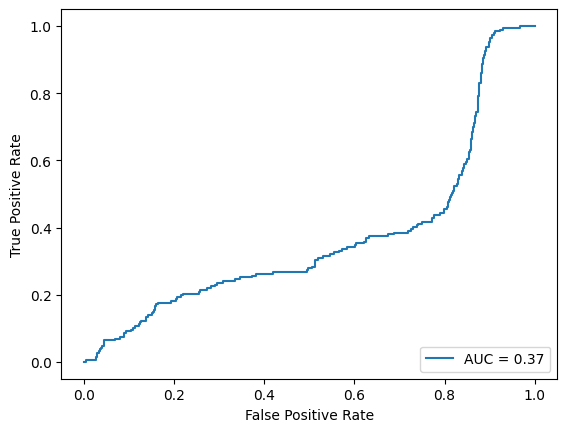

In [120]:
fpr, tpr, thresholds = metrics.roc_curve(by_kurtosis["bound"], by_kurtosis["kurtosis"], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

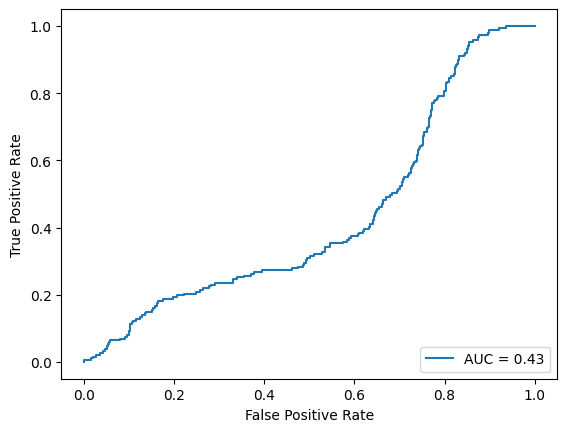

In [121]:
fpr, tpr, thresholds = metrics.roc_curve(by_skew["bound"], by_skew["skew"], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

## Statistics Using New Phases

#### Generate New MTZ Files

In [174]:
path_to_mtzs = '../PTP1B_DK/recons_mtzs/'
path_to_phase_mtzs = '../pandda_input_models_refined/'

for file_path in tqdm(os.listdir(path_to_mtzs)):

    try:
        # check if mtz exists, read diff_map, reindex if necessary
        recons_diff_map = rs.read_mtz(path_to_mtzs + file_path)
        sample = re.search('[0-9]{4}', file_path).group()

        phase_mtz = rs.read_mtz(path_to_phase_mtzs + f'PTP1B_y{sample}_recons_refined_phases.mtz')
        
        recons_diff_map['refine_PHFOFCWT'] = phase_mtz['PHFOFCWT']
        recons_diff_map['refine_PH2FOFCWT'] = phase_mtz['PH2FOFCWT']
        
        recons_diff_map.write_mtz(f'../recons_refined_phases/PTP1B_y{sample}_recons_refined_phases.mtz')
        
    except:
        continue

  0%|          | 0/1683 [00:00<?, ?it/s]

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array


#### Generate Results with New Phases

In [23]:
recons_refined_stats_df = generate_diff_map_stats('../recons_refined_phases/', 'F-obs-diff', 'refine_PH2FOFCWT')

  0%|          | 0/1629 [00:00<?, ?it/s]

In [24]:
recons_refined_stats_df

,sample,reindex,bound,mean,sd,skew,kurtosis
0,1759,0,1,-1.505787e-09,1.0,0.130822,1.895934
1,1587,0,0,-1.782161e-10,1.0,0.041632,0.186636
2,1597,1,0,-4.019975e-10,1.0,-0.033762,0.098360
3,1421,1,0,-6.998844e-10,1.0,0.032650,0.306481
4,1007,1,0,4.823970e-10,1.0,0.022734,0.641666
...,...,...,...,...,...,...,...
1620,0043,1,0,-6.726219e-11,1.0,0.412774,11.053685
1621,1918,1,0,1.158979e-09,1.0,0.047934,0.295194
1622,0422,1,0,4.905732e-10,1.0,0.074190,0.821190
1623,0623,0,1,4.423782e-10,1.0,-0.016821,0.259751


#### Classifying Bound vs Not

In [25]:
recons_refined_stats_df['apo'] = [1 if x in apo_samples else 0 for x in recons_refined_stats_df['sample']]
apo_stats = recons_refined_stats_df[recons_refined_stats_df['apo'] == 1]
holo_stats = recons_refined_stats_df[recons_refined_stats_df['apo'] == 0]

In [26]:
reindex_bound_stats = recons_refined_stats_df[(recons_refined_stats_df['reindex'] == 1) & (recons_refined_stats_df['bound'] == 1)]
reindex_not_bound_stats = recons_refined_stats_df[(recons_refined_stats_df['reindex'] == 1) & (recons_refined_stats_df['bound'] == 0)]
reindex_stats = recons_refined_stats_df[(recons_refined_stats_df['reindex'] == 1)]

no_reindex_bound_stats = recons_refined_stats_df[(recons_refined_stats_df['reindex'] == 0) & (recons_refined_stats_df['bound'] == 1)]
no_reindex_not_bound_stats = recons_refined_stats_df[(recons_refined_stats_df['reindex'] == 0) & (recons_refined_stats_df['bound'] == 0)]
no_reindex_stats = recons_refined_stats_df[(recons_refined_stats_df['reindex'] == 0)]

bound_stats = recons_refined_stats_df[(recons_refined_stats_df['bound'] == 1)]
not_bound_stats = recons_refined_stats_df[(recons_refined_stats_df['bound'] == 0)]

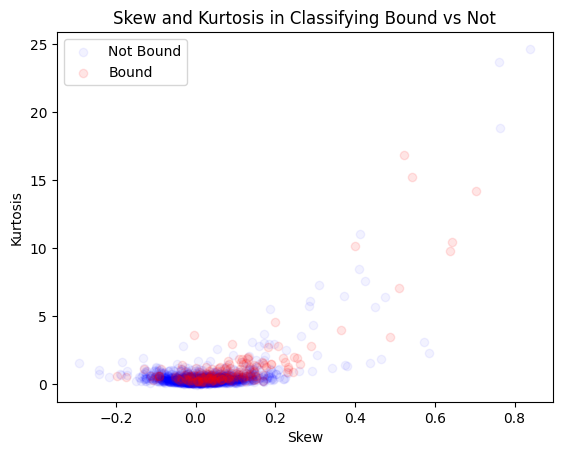

In [27]:
plt.scatter(not_bound_stats['skew'], not_bound_stats['kurtosis'], color="blue", label='Not Bound', alpha=0.05)
plt.scatter(bound_stats['skew'], bound_stats['kurtosis'], color="red", label='Bound', alpha=0.1)
plt.xlabel("Skew")
plt.ylabel("Kurtosis")
plt.title("Skew and Kurtosis in Classifying Bound vs Not")
plt.legend()
plt.show()

#### Histograms (Classifying Bound vs Not)

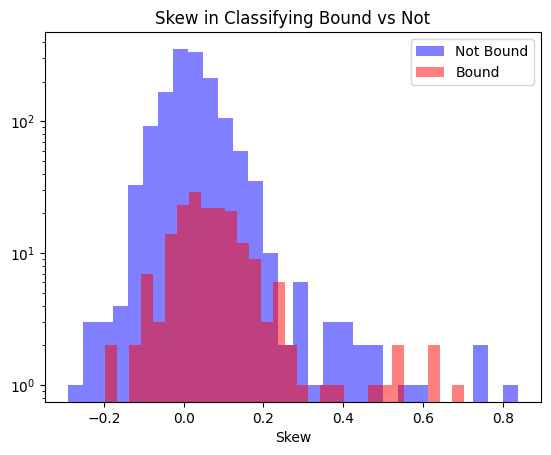

In [28]:
plt.hist(not_bound_stats['skew'], color="blue", label='Not Bound', alpha=0.5, bins=30)
plt.hist(bound_stats['skew'], color="red", label='Bound', alpha=0.5, bins=30)
plt.xlabel("Skew")
plt.yscale("log")
plt.title("Skew in Classifying Bound vs Not")
plt.legend()
plt.show()

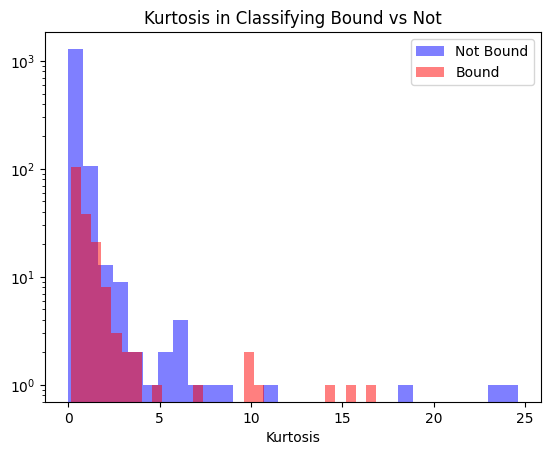

In [29]:
plt.hist(not_bound_stats['kurtosis'], color="blue", label='Not Bound', alpha=0.5, bins=30)
plt.hist(bound_stats['kurtosis'], color="red", label='Bound', alpha=0.5, bins=30)
plt.xlabel("Kurtosis")
plt.yscale("log")
plt.title("Kurtosis in Classifying Bound vs Not")
plt.legend()
plt.show()

#### Saving Statistics

In [30]:
by_kurtosis = recons_refined_stats_df.sort_values(by="kurtosis", ascending=False).reset_index(drop=True)
by_skew = recons_refined_stats_df.sort_values(by="skew", ascending=False).reset_index(drop=True)

In [31]:
recons_refined_stats_df.to_pickle('../recons_refined_phases/refine_stats_df.pkl')
by_kurtosis.to_pickle('../recons_refined_phases/refine_stats_df_by_kurtosis.pkl')
by_skew.to_pickle('../recons_refined_phases/refine_stats_df_by_skew.pkl')

#### AUCs

In [32]:
stats_df = pd.read_pickle('../recons_refined_phases/refine_stats_df.pkl')
by_kurtosis = pd.read_pickle('../recons_refined_phases/refine_stats_df_by_kurtosis.pkl')
by_skew = pd.read_pickle('../recons_refined_phases/refine_stats_df_by_skew.pkl')

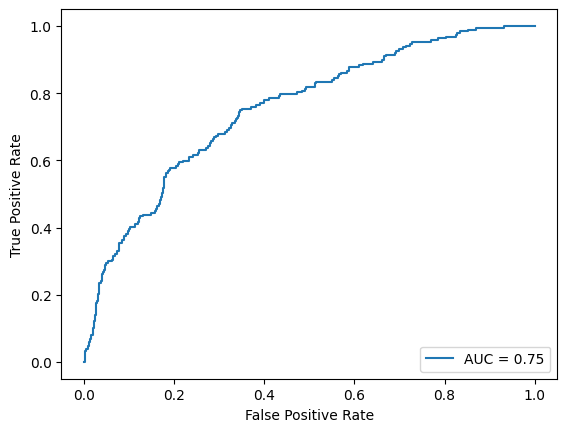

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(by_kurtosis["bound"], by_kurtosis["kurtosis"], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

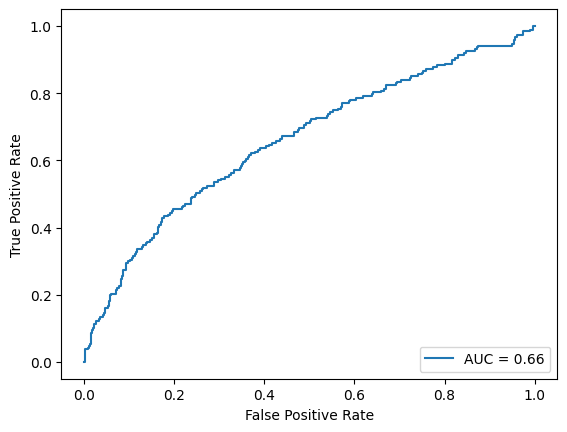

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(by_skew["bound"], by_skew["skew"], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

## Working

#### Generate Blob Results

In [16]:
def mtzs_file_fxn(sample_no):
    return f'../recons_refined_phases/PTP1B_y{sample_no}_recons_refined_phases.mtz'

def structure_file_fxn(sample_no):
    return f'../pandda_input_models_refined/PTP1B_y{sample_no}_pandda_input_reindexed_refine_001.pdb'

In [23]:
peaks, blob_stats = generate_diff_map_blobs(samples, mtzs_file_fxn, structure_file_fxn, "F-obs-diff", "refine_PH2FOFCWT", cutoff=1.5, min_peak=2.5)

  0%|          | 0/1958 [00:00<?, ?it/s]

In [24]:
peaks_df = pd.DataFrame(peaks)
blob_stats_df = pd.DataFrame(blob_stats)

In [25]:
peaks_df.to_pickle('../recons_refined_phases/blob_identification/peak_15_25_df.pkl')
blob_stats_df.to_pickle('../recons_refined_phases/blob_identification/blob_stats_15_25_df.pkl')

In [26]:
results_df = blob_stats_df[['sample', 'bound']].drop_duplicates()

In [38]:
blob_stats_df = pd.read_pickle('../recons_refined_phases/blob_identification/blob_stats_25_35_df.pkl')
results_df = blob_stats_df[['sample', 'bound']].drop_duplicates()
results_df

,sample,bound
0,0001,0
4,0002,0
12,0009,0
29,0010,0
30,0012,0
...,...,...
4695,1959,0
4696,1960,0
4704,1963,0
4705,1964,0


In [39]:
set(bound_samples).difference(set(results_df[results_df['bound']==1]['sample']))

{'0234',
 '0241',
 '0559',
 '0634',
 '0639',
 '0654',
 '0953',
 '1163',
 '1343',
 '1402'}

#### Add Poor R-Factor, Skew/Kurtosis Columns

In [110]:
blob_stats_df = pd.read_pickle('../recons_refined_phases/blob_identification/blob_stats_df.pkl')
blob_stats_df = blob_stats_df.astype({"sample": int})

In [111]:
r_factors = pd.read_csv('../pandda_input_models_refined/refine_stats.csv', index_col=0)[['data_id', 'Rfree_final']]

In [112]:
skew_kurtosis_df = pd.read_pickle('../recons_refined_phases/refine_stats_df.pkl')
skew_kurtosis_df = skew_kurtosis_df.astype({"sample": int})
cols_to_use = list(skew_kurtosis_df.columns.difference(blob_stats_df.columns))
cols_to_use.append('sample')

In [113]:
blob_stats_df = blob_stats_df.merge(r_factors, left_on='sample', right_on='data_id')

In [114]:
blob_stats_df = blob_stats_df.merge(skew_kurtosis_df[cols_to_use], left_on='sample', right_on='sample')

In [115]:
blob_stats_df['high_Rfree'] = [1 if x > 0.4 else 0 for x in blob_stats_df['Rfree_final']]

In [116]:
blob_stats_df.to_pickle('../recons_refined_phases/blob_identification/blob_stats_df_r_skew_kurtosis.pkl')

#### Adding Cys215 Oxidation Column

In [6]:
blob_stats_df = pd.read_pickle('../recons_refined_phases/blob_identification/blob_stats_df_r_skew_kurtosis.pkl')

In [7]:
blob_stats_df = blob_stats_df[blob_stats_df['high_Rfree'] == 0]

In [8]:
blob_stats_df[['peakz_z', 'scorez_z', 'cenx_z', 'ceny_z', 'cenz_z']] = StandardScaler().fit_transform(blob_stats_df[['peakz', 'scorez', 'cenx', 'ceny', 'cenz']])

In [9]:
blob_stats_df['blob_id'] = np.arange(0, len(blob_stats_df))

In [11]:
def euclidean_distance(df, components, output_cols):
    
    results = []
    
    for i in tqdm(range(len(df))):
        for j in range(len(df)):
            
            if i == j:
                continue
            
            row_1 = df.iloc[i]
            row_2 = df.iloc[j]
            
            current = {
                'dist': np.sqrt(np.sum((row_2[components] - row_1[components])**2))
            }
            
            for col in output_cols:
                current[col+'_1'] = row_1[col]
                current[col+'_2'] = row_2[col]
            
            results.append(current)
            
    return results

##### Standardized

In [201]:
dist_df = pd.DataFrame(euclidean_distance(blob_stats_df, ['peakz_z', 'scorez_z', 'cenx_z', 'ceny_z', 'cenz_z']))

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

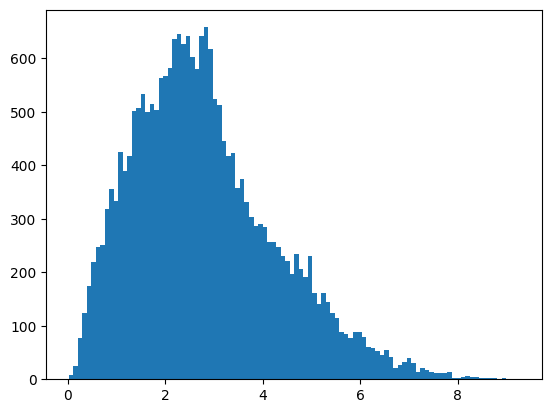

In [202]:
plt.hist(dist_df['dist'], bins=100)
plt.show()

##### No Standardization

In [61]:
dist_no_std_df = pd.DataFrame(euclidean_distance(blob_stats_df, ['peakz', 'scorez', 'cenx', 'ceny', 'cenz'], ['sample', 'peakz', 'scorez', 'cenx', 'ceny', 'cenz', 'bound', 'apo', 'blob_id']))

  0%|          | 0/213 [00:00<?, ?it/s]

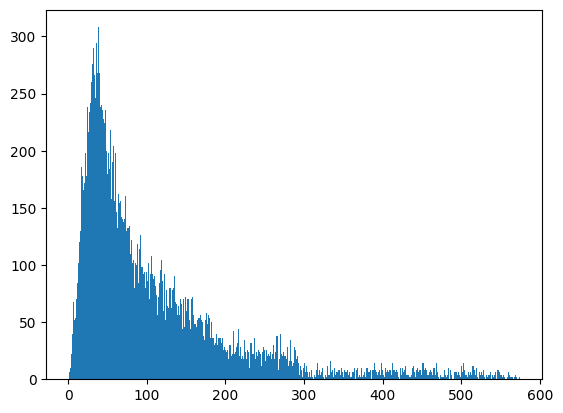

In [62]:
plt.hist(dist_no_std_df['dist'], bins=1000)
plt.show()

In [63]:
dist_no_std_df.sort_values(by=['dist'])

,dist,sample_1,sample_2,peakz_1,peakz_2,scorez_1,scorez_2,cenx_1,cenx_2,ceny_1,ceny_2,cenz_1,cenz_2,bound_1,bound_2,apo_1,apo_2,blob_id_1,blob_id_2
21097,0.573062,911.0,1009.0,7.208970,7.207743,104.185493,104.722079,8.421684,8.377893,45.641958,45.833370,8.421684,8.377893,1.0,1.0,0.0,0.0,99.0,110.0
23419,0.573062,1009.0,911.0,7.207743,7.208970,104.722079,104.185493,8.377893,8.421684,45.833370,45.641958,8.377893,8.421684,1.0,1.0,0.0,0.0,110.0,99.0
11713,1.006360,581.0,580.0,11.044401,10.428509,73.791548,73.014404,8.970657,8.858931,51.081304,51.148527,8.970657,8.858931,0.0,1.0,0.0,0.0,55.0,53.0
11290,1.006360,580.0,581.0,10.428509,11.044401,73.014404,73.791548,8.858931,8.970657,51.148527,51.081304,8.858931,8.970657,1.0,0.0,0.0,0.0,53.0,55.0
6170,1.027957,209.0,193.0,8.525123,8.130464,69.140823,68.562050,5.640027,5.981168,49.174773,49.752014,5.640027,5.981168,0.0,1.0,0.0,0.0,29.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7793,570.225450,363.0,1608.0,5.674376,24.134620,48.270380,618.182567,25.861445,24.768293,22.934753,19.194184,25.861445,24.768293,1.0,1.0,0.0,0.0,36.0,162.0
34536,571.836527,1608.0,1804.0,24.134620,6.125918,618.182567,47.762603,24.768293,8.160114,19.194184,46.435729,24.768293,8.160114,1.0,1.0,0.0,0.0,162.0,193.0
41078,571.836527,1804.0,1608.0,6.125918,24.134620,47.762603,618.182567,8.160114,24.768293,46.435729,19.194184,8.160114,24.768293,1.0,1.0,0.0,0.0,193.0,162.0
42986,574.029351,1910.0,1608.0,6.177023,24.134620,46.423026,618.182567,-4.649262,24.768293,42.592126,19.194184,-4.649262,24.768293,0.0,1.0,0.0,0.0,202.0,162.0


In [64]:
blob_stats_df[blob_stats_df['sample'] == 562]

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,...,mean,sd,skew,high_Rfree,peakz_z,scorez_z,cenx_z,ceny_z,cenz_z,blob_id
47,562,36.694102,319.316190,36.694096,319.316133,7.437864,48.741360,7.437864,0,0,...,-8.993842e-11,1.0,0.839626,0,3.838964,1.668742,0.290703,0.326312,0.290703,46
48,562,7.662895,55.307585,7.662893,55.307575,5.720847,44.658082,5.720847,0,0,...,-8.993842e-11,1.0,0.839626,0,-0.721149,-0.828634,0.142558,0.050596,0.142558,47


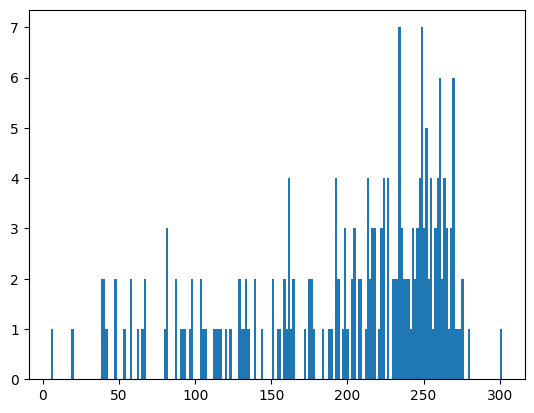

In [68]:
plt.hist(dist_no_std_df[dist_no_std_df['blob_id_1']==46]['dist'], bins=200)
plt.show()

In [71]:
dist_no_std_df[dist_no_std_df['blob_id_1']==47].sort_values(by='dist').head(50)

,dist,sample_1,sample_2,peakz_1,peakz_2,scorez_1,scorez_2,cenx_1,cenx_2,ceny_1,ceny_2,cenz_1,cenz_2,bound_1,bound_2,apo_1,apo_2,blob_id_1,blob_id_2
10084,1.217205,562.0,1194.0,7.662895,7.010059,55.307585,56.286275,5.720847,5.888079,44.658082,44.454060,5.720847,5.888079,0.0,0.0,0.0,0.0,47.0,121.0
9999,4.896015,562.0,295.0,7.662895,6.416366,55.307585,54.673889,5.720847,7.311232,44.658082,48.775959,5.720847,7.311232,0.0,0.0,0.0,0.0,47.0,35.0
10023,5.844182,562.0,597.0,7.662895,8.648406,55.307585,57.945868,5.720847,9.264536,44.658082,43.605825,5.720847,9.264536,0.0,0.0,0.0,0.0,47.0,60.0
10071,6.069233,562.0,1002.0,7.662895,8.615613,55.307585,58.332238,5.720847,7.703976,44.658082,49.007080,5.720847,7.703976,0.0,0.0,0.0,0.0,47.0,108.0
10085,7.044926,562.0,1242.0,7.662895,10.170923,55.307585,59.514745,5.720847,9.248467,44.658082,43.790683,5.720847,9.248467,0.0,1.0,0.0,0.0,47.0,122.0
10164,7.576723,562.0,1910.0,7.662895,5.438023,55.307585,50.974795,5.720847,3.621620,44.658082,49.645074,5.720847,3.621620,0.0,0.0,0.0,0.0,47.0,201.0
10058,7.873209,562.0,871.0,7.662895,6.196287,55.307585,51.300456,5.720847,4.588004,44.658082,51.077796,5.720847,4.588004,0.0,0.0,0.0,0.0,47.0,95.0
10156,8.622594,562.0,1804.0,7.662895,6.125918,55.307585,47.762603,5.720847,8.160114,44.658082,46.435729,5.720847,8.160114,0.0,1.0,0.0,0.0,47.0,193.0
10174,9.559562,562.0,1957.0,7.662895,6.693329,55.307585,57.099143,5.720847,11.983511,44.658082,41.692686,5.720847,11.983511,0.0,1.0,0.0,0.0,47.0,211.0
10057,9.925524,562.0,871.0,7.662895,6.868207,55.307585,59.484968,5.720847,9.048858,44.658082,52.292389,5.720847,9.048858,0.0,0.0,0.0,0.0,47.0,94.0


#### HDBSCAN

In [12]:
import hdbscan

In [13]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=3, gen_min_span_tree=True)

In [22]:
test_data = blob_stats_df[['peakz_z', 'scorez_z', 'cenx_z', 'ceny_z', 'cenz_z']]

In [23]:
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=2, min_samples=3)

In [24]:
clusterer.labels_

array([ 9, -1, -1,  9,  9, -1, 10,  9, -1,  1,  2,  9,  8,  9,  9,  9,  9,
       -1,  9, -1,  5,  8,  9, -1, -1, 11,  9, -1,  9,  9, -1,  6, -1,  4,
       10,  9,  1, -1, -1, -1, -1,  9,  9,  8,  9,  8, -1,  9,  6, -1, -1,
       10,  9,  9,  9,  9,  9, 10,  9,  9,  9,  9,  9,  9,  9,  9,  9,  1,
        1,  1,  1, -1, -1,  9,  9,  9,  9,  5,  9,  9,  9,  5,  5, 10,  9,
        9,  9,  9, 10, -1, 10, 10, 11,  9,  9,  9, -1,  1,  9,  9, -1,  8,
        9, -1,  9,  9,  5,  9,  9,  9,  9, -1, -1,  9, -1,  9,  2,  9, -1,
        5, -1,  9,  9,  9, -1, -1,  1,  1,  8,  9,  9,  9, 11,  0,  5,  1,
       10, -1, -1,  3,  9, -1, -1, 10, -1,  5,  9,  9, -1,  9,  9, -1, -1,
        5,  9,  9, -1,  1,  0,  5, -1,  9,  0, -1,  9, -1,  1,  6, -1, 11,
        0, -1,  9,  9,  9, -1, -1,  9,  7,  1,  5,  9,  9,  3,  9,  9, -1,
       -1,  9, -1, -1, -1,  9,  9,  9,  1,  1,  1, -1, -1,  5,  9,  7, -1,
        9,  9,  1, -1, -1,  8, 11,  9,  4])

In [25]:
blob_cluster_df = blob_stats_df
blob_cluster_df['cluster'] = clusterer.labels_

In [26]:
blob_cluster_df[blob_cluster_df['cluster']==1]

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,...,sd,skew,high_Rfree,peakz_z,scorez_z,cenx_z,ceny_z,cenz_z,blob_id,cluster
9,90,5.769983,49.881433,5.769983,49.881433,25.761623,19.294403,25.761623,1,0,...,1.0,0.068221,0,-1.018480,-0.879962,1.871681,-1.662045,1.871681,9,1
36,363,5.674376,48.270380,5.674377,48.270385,25.861445,22.934753,25.861445,0,1,...,1.0,0.006685,0,-1.033498,-0.895202,1.880294,-1.416237,1.880294,36,1
68,660,9.307631,179.704439,9.307631,179.704439,28.716067,8.549941,28.716067,1,1,...,1.0,0.033786,0,-0.462800,0.348092,2.126592,-2.387548,2.126592,67,1
69,660,7.598457,69.544192,7.598457,69.544192,33.698643,8.152877,33.698643,1,1,...,1.0,0.033786,0,-0.731271,-0.693963,2.556490,-2.414359,2.556490,68,1
70,660,7.281920,58.522925,7.281920,58.522925,32.123937,3.415909,32.123937,1,1,...,1.0,0.033786,0,-0.780991,-0.798218,2.420624,-2.734215,2.420624,69,1
71,676,7.054817,69.250546,7.054817,69.250546,25.246260,18.056017,25.246260,0,1,...,1.0,-0.087245,0,-0.816664,-0.696741,1.827216,-1.745665,1.827216,70,1
98,891,11.370483,107.938645,11.370484,107.938657,23.175291,18.295894,23.175291,1,1,...,1.0,0.048922,0,-0.138775,-0.330773,1.648532,-1.729468,1.648532,97,1
129,1264,11.484954,90.147636,11.484953,90.147625,24.579333,19.724922,24.579333,1,1,...,1.0,0.205637,0,-0.120794,-0.499066,1.769673,-1.632975,1.769673,126,1
130,1264,7.533826,54.684303,7.533825,54.684297,26.867480,15.784449,26.867480,1,1,...,1.0,0.205637,0,-0.741423,-0.834530,1.967095,-1.899049,1.967095,127,1
138,1318,7.449747,88.567013,7.449747,88.567013,23.379372,18.873300,23.379372,0,1,...,1.0,0.060777,0,-0.754629,-0.514018,1.666140,-1.690480,1.666140,135,1


#### HAC

In [27]:
from sklearn.cluster import AgglomerativeClustering

In [28]:
test_data = blob_stats_df[['peakz_z', 'scorez_z', 'cenx_z', 'ceny_z', 'cenz_z']]

In [29]:
clustering = AgglomerativeClustering(linkage='complete', compute_full_tree=True, distance_threshold=0.85, n_clusters=None).fit(test_data)

##### Dendrogram

In [44]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

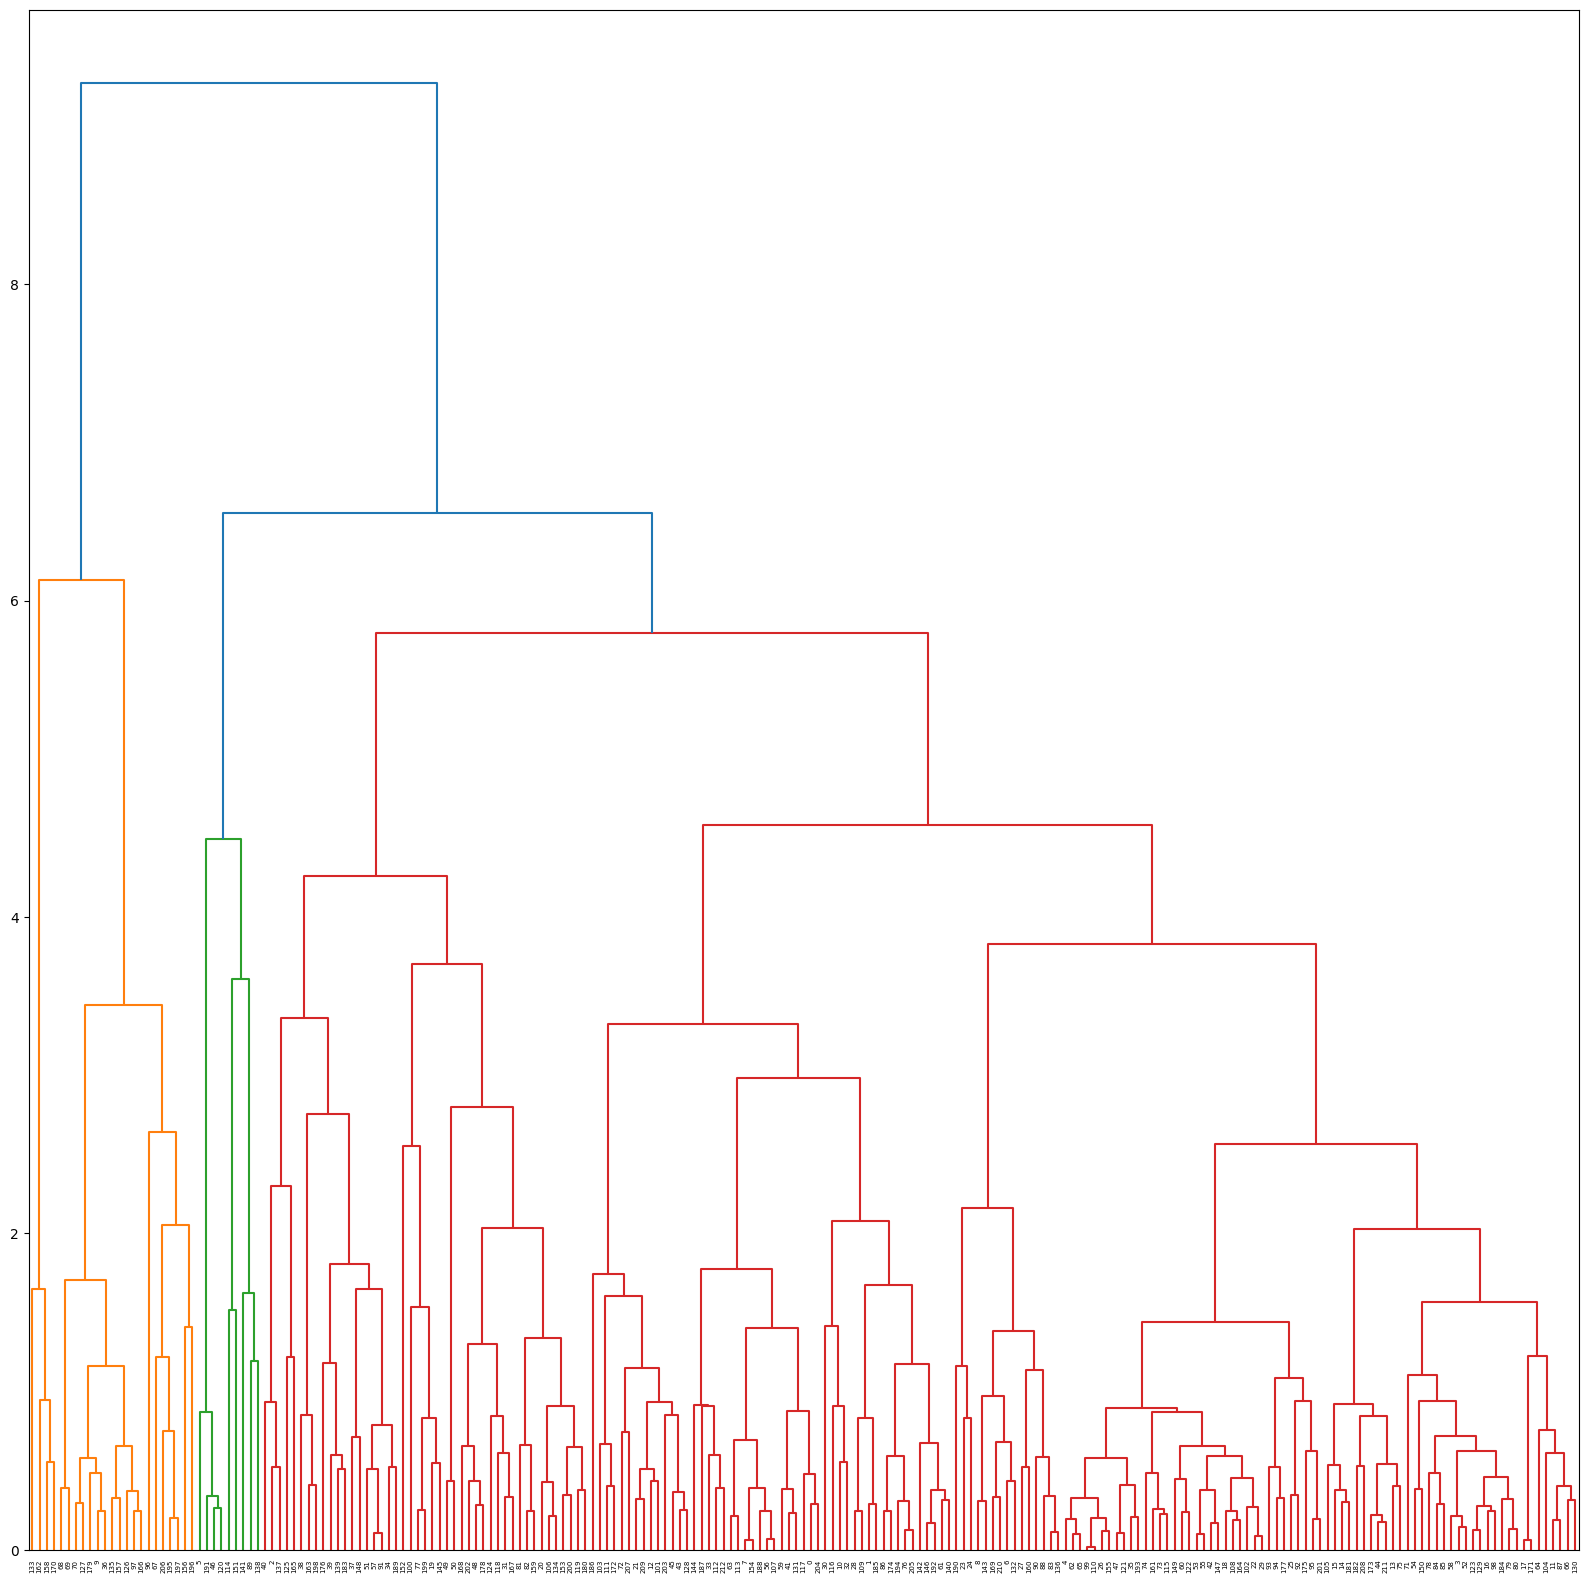

In [51]:
plt.figure(figsize=(20, 20))
plot_dendrogram(clustering)

##### Analyze Clusters

In [52]:
blob_cluster_df = blob_stats_df
blob_cluster_df['cluster'] = clustering.labels_

In [57]:
blob_cluster_df[blob_cluster_df['cluster'] == 0]

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,...,sd,skew,high_Rfree,peakz_z,scorez_z,cenx_z,ceny_z,cenz_z,blob_id,cluster
31,249,6.971638,52.247367,6.971637,52.247363,-9.459630,48.530075,-9.459630,0,1,...,1.0,0.107395,0,-0.829729,-0.857582,-1.167218,0.312046,-1.167218,31,0
121,1159,6.822905,61.481749,6.822905,61.481749,-13.841062,45.310876,-13.841062,0,0,...,1.0,0.078537,0,-0.853092,-0.770230,-1.545249,0.094675,-1.545249,118,0
127,1257,7.806112,119.476502,7.806111,119.476495,-8.896586,47.944152,-8.896586,1,1,...,1.0,0.146806,0,-0.698653,-0.221631,-1.118638,0.272482,-1.118638,124,0
175,1616,6.858901,82.519031,6.858903,82.519060,-10.184811,50.763618,-10.184811,0,0,...,1.0,0.573120,0,-0.847437,-0.571228,-1.229787,0.462862,-1.229787,167,0


In [150]:
blob_cluster_df[blob_cluster_df['sample']==562]

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,...,sd,skew,high_Rfree,peakz_z,scorez_z,cenx_z,ceny_z,cenz_z,blob_id,cluster
47,562,36.694102,319.316190,36.694096,319.316133,7.437864,48.741360,7.437864,0,0,...,1.0,0.839626,0,3.838964,1.668742,0.290703,0.326312,0.290703,46,63
48,562,7.662895,55.307585,7.662893,55.307575,5.720847,44.658082,5.720847,0,0,...,1.0,0.839626,0,-0.721149,-0.828634,0.142558,0.050596,0.142558,47,33


##### Sort DataFrame by Cluster (Clusters from Highest Score Downwards)

In [69]:
clusters_df = blob_cluster_df.groupby(['cluster'])[['peakz', 'scorez']].mean().sort_values(by='scorez', ascending=False)

In [71]:
sorted_cluster_list = list(clusters_df.index)

In [114]:
def sort_df_by_column(df, column, sorted_value_list):
    # Create a new column called 'sort_key' with the same values as the specified column
    df['sort_key'] = df[column]

    # Map the values in 'sort_key' to their position in 'sorted_value_list'
    df['sort_key'] = df['sort_key'].map(lambda x: sorted_value_list.index(x))

    # Sort the DataFrame by 'sort_key' in ascending order
    df = df.sort_values(by='sort_key', ascending=True)

    # Drop the 'sort_key' column
    df = df.drop(columns=['sort_key'])

    return df

In [116]:
sorted_clusters_df = sort_df_by_column(blob_cluster_df, "cluster", sorted_cluster_list)

In [118]:
sorted_clusters_df.head(50)

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,...,sd,skew,high_Rfree,peakz_z,scorez_z,cenx_z,ceny_z,cenz_z,blob_id,cluster
170,1608,24.134620,618.182567,24.134613,618.182383,24.768293,19.194184,24.768293,0,1,...,1.000000,0.639057,0,1.866168,4.495853,1.785977,-1.668813,1.785977,162,58
117,1125,21.246877,597.507037,21.246876,597.507001,-10.315168,32.270771,-10.315168,1,1,...,1.000000,0.643126,0,1.412572,4.300274,-1.241034,-0.785837,-1.241034,114,37
166,1554,27.774861,571.726725,27.774864,571.726793,24.393925,19.153010,24.393925,0,1,...,1.000000,0.523978,0,2.437963,4.056407,1.753676,-1.671593,1.753676,158,38
178,1618,25.837137,522.472735,25.837143,522.472859,24.408384,19.188899,24.408384,1,1,...,1.000000,0.400445,0,2.133593,3.590491,1.754924,-1.669169,1.754924,170,38
144,1417,20.521863,510.766534,20.521866,510.766595,-3.756146,71.302792,-3.756146,0,1,...,1.000000,0.511095,0,1.298689,3.479757,-0.675120,1.849736,-0.675120,141,68
136,1312,19.081102,475.311391,19.081102,475.311391,25.289418,19.361587,25.289418,1,1,...,1.000000,0.488226,0,1.072380,3.144371,1.830939,-1.657509,1.830939,133,65
157,1492,24.948076,449.609611,24.948076,449.609611,-9.673863,32.154700,-9.673863,1,1,...,1.000000,0.703743,0,1.993942,2.901246,-1.185702,-0.793675,-1.185702,151,43
141,1335,22.059905,400.577635,22.059902,400.577588,-13.552228,69.373750,-13.552228,0,1,...,1.000000,0.199546,0,1.540279,2.437431,-1.520328,1.719481,-1.520328,138,53
194,1759,12.647375,360.720389,12.647375,360.720389,8.763053,45.069111,8.763053,0,1,...,1.000000,0.130822,0,0.061794,2.060403,0.405040,0.078350,0.405040,186,57
90,845,21.114032,340.353134,21.114031,340.353114,-5.075367,70.632178,-5.075367,0,1,...,1.000000,0.365094,0,1.391705,1.867740,-0.788942,1.804454,-0.788942,89,48
